In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize all RGB channels
])


In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root='/kaggle/working', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='/kaggle/working', train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:05<00:00, 29.7MB/s] 


Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working
Files already downloaded and verified


In [6]:
def filter_classes(dataset, classes=[3, 5]):
    indices = [i for i, (_, label) in enumerate(dataset) if label in classes]
    return Subset(dataset, indices)

train_cats_dogs = filter_classes(train_dataset, classes=[3, 5])
test_cats_dogs = filter_classes(test_dataset, classes=[3, 5])


In [7]:
batch_size = 64

train_loader = DataLoader(train_cats_dogs, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_cats_dogs, batch_size=batch_size, shuffle=False, num_workers=2)


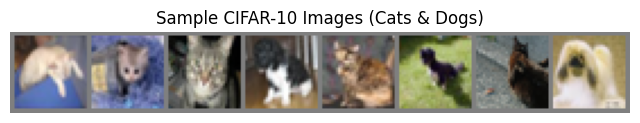

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # denormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Sample CIFAR-10 Images (Cats & Dogs)")
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # -> [32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> [64, 8, 8]
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> [32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),   # -> [3, 32, 32]
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.fc_mu(enc)
        logvar = self.fc_logvar(enc)
        z = self.reparameterize(mu, logvar)
        dec = self.fc_decode(z).view(-1, 64, 8, 8)
        x_recon = self.decoder(dec)
        return x_recon, mu, logvar


In [10]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


In [11]:
vae = VAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    vae.train()
    running_loss = 0.0
    
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.2f}")


Epoch [1/20], Loss: 412.95
Epoch [2/20], Loss: 272.39
Epoch [3/20], Loss: 241.33
Epoch [4/20], Loss: 225.86
Epoch [5/20], Loss: 216.76
Epoch [6/20], Loss: 211.32
Epoch [7/20], Loss: 207.92
Epoch [8/20], Loss: 205.12
Epoch [9/20], Loss: 202.73
Epoch [10/20], Loss: 199.94
Epoch [11/20], Loss: 198.38
Epoch [12/20], Loss: 197.45
Epoch [13/20], Loss: 195.93
Epoch [14/20], Loss: 194.98
Epoch [15/20], Loss: 193.97
Epoch [16/20], Loss: 193.38
Epoch [17/20], Loss: 192.60
Epoch [18/20], Loss: 191.63
Epoch [19/20], Loss: 191.29
Epoch [20/20], Loss: 190.96


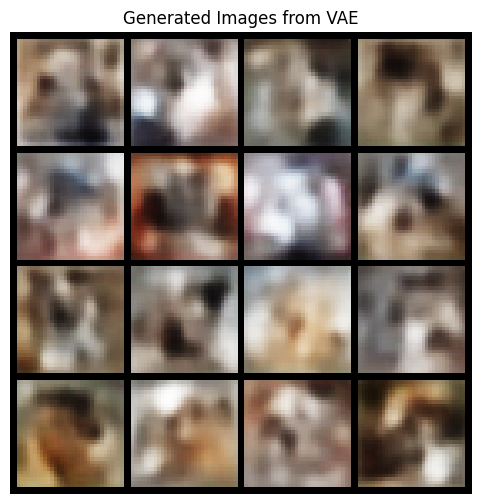

In [12]:
vae.eval()
with torch.no_grad():
    z = torch.randn(16, vae.latent_dim).to(device)
    gen = vae.decoder(vae.fc_decode(z).view(-1, 64, 8, 8))
    gen = gen.cpu() * 0.5 + 0.5  # denormalize

    grid = torchvision.utils.make_grid(gen, nrow=4)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title("Generated Images from VAE")
    plt.show()


In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 32x32
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


In [14]:
class SimilarityDiscriminator(nn.Module):
    def __init__(self):
        super(SimilarityDiscriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU()
        )
        self.similarity_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),  # Output: similarity score
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        feat1 = self.feature_extractor(img1)
        feat2 = self.feature_extractor(img2)
        diff = torch.abs(feat1 - feat2)
        score = self.similarity_head(diff)
        return score


In [15]:
latent_dim = 128

G = Generator(latent_dim).to(device)
D = SimilarityDiscriminator().to(device)

g_optimizer = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce_loss = nn.BCELoss()


In [16]:
epochs = 50
for epoch in range(epochs):
    G.train()
    D.train()
    d_loss_total, g_loss_total = 0, 0
    
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)

        # Randomly pair real & fake images
        real_pair = real_imgs
        fake_pair = fake_imgs.detach()

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_optimizer.zero_grad()
        d_real_score = D(real_pair, real_pair)  # similarity of real with real
        d_fake_score = D(real_pair, fake_pair)  # similarity of real with fake

        d_loss_real = bce_loss(d_real_score, real_labels)
        d_loss_fake = bce_loss(d_fake_score, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = G(z)

        g_loss = bce_loss(D(real_pair, gen_imgs), real_labels)
        g_loss.backward()
        g_optimizer.step()

        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss_total:.2f}, G Loss: {g_loss_total:.2f}")


Epoch [1/50], D Loss: 108.83, G Loss: 1238.95
Epoch [2/50], D Loss: 87.50, G Loss: 1998.13
Epoch [3/50], D Loss: 67.59, G Loss: 2362.55
Epoch [4/50], D Loss: 48.26, G Loss: 2606.86
Epoch [5/50], D Loss: 33.12, G Loss: 2801.99
Epoch [6/50], D Loss: 22.66, G Loss: 2961.30
Epoch [7/50], D Loss: 15.81, G Loss: 3087.51
Epoch [8/50], D Loss: 11.33, G Loss: 3224.45
Epoch [9/50], D Loss: 8.35, G Loss: 3345.29
Epoch [10/50], D Loss: 6.32, G Loss: 3460.15
Epoch [11/50], D Loss: 4.90, G Loss: 3553.86
Epoch [12/50], D Loss: 3.87, G Loss: 3642.56
Epoch [13/50], D Loss: 3.11, G Loss: 3732.16
Epoch [14/50], D Loss: 2.54, G Loss: 3824.32
Epoch [15/50], D Loss: 2.09, G Loss: 3905.62
Epoch [16/50], D Loss: 1.75, G Loss: 3986.24
Epoch [17/50], D Loss: 1.47, G Loss: 4066.98
Epoch [18/50], D Loss: 1.25, G Loss: 4138.28
Epoch [19/50], D Loss: 1.07, G Loss: 4206.01
Epoch [20/50], D Loss: 0.92, G Loss: 4271.33
Epoch [21/50], D Loss: 0.80, G Loss: 4333.47
Epoch [22/50], D Loss: 0.69, G Loss: 4397.09
Epoch [23/

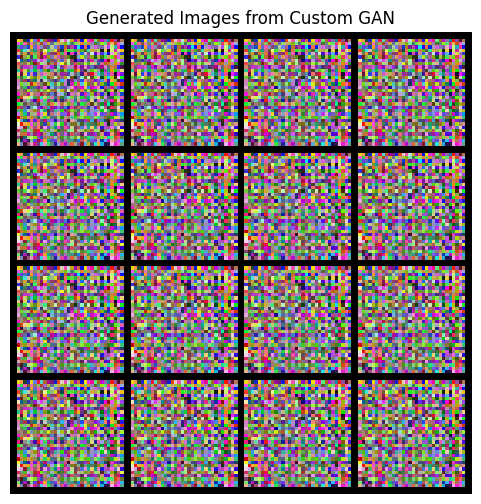

In [17]:
G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    gen_imgs = G(z).cpu() * 0.5 + 0.5  # denormalize

    grid = torchvision.utils.make_grid(gen_imgs, nrow=4)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title("Generated Images from Custom GAN")
    plt.show()


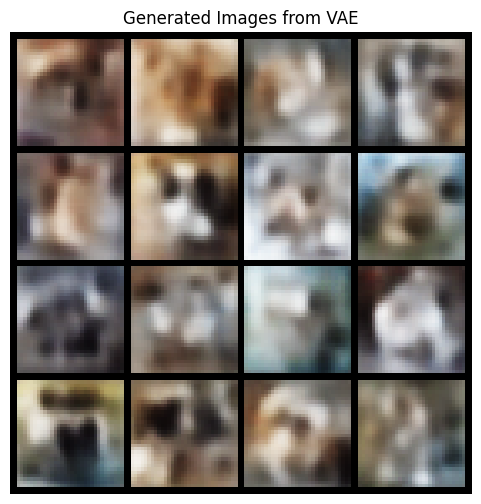

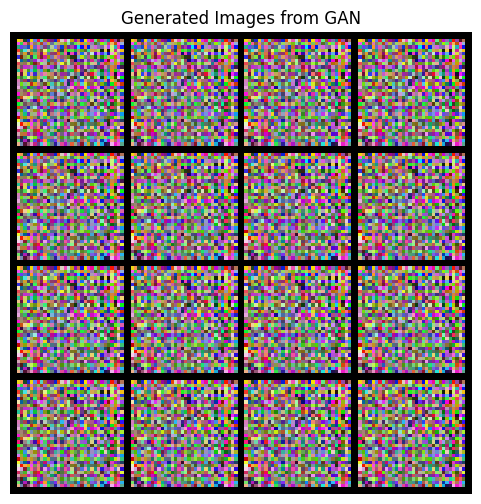

In [32]:
# Visualize VAE generated images
vae.eval()
with torch.no_grad():
    z = torch.randn(16, vae.latent_dim).to(device)
    vae_gen_imgs = vae.decoder(vae.fc_decode(z).view(-1, 64, 8, 8)).cpu() * 0.5 + 0.5  # denormalize

vae_grid = torchvision.utils.make_grid(vae_gen_imgs, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(np.transpose(vae_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Generated Images from VAE")
plt.show()

# Visualize GAN generated images
G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    gan_gen_imgs = G(z).cpu() * 0.5 + 0.5  # denormalize

gan_grid = torchvision.utils.make_grid(gan_gen_imgs, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(np.transpose(gan_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Generated Images from GAN")
plt.show()


In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Image Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize all RGB channels
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='/kaggle/working', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(
    root='/kaggle/working', train=False, download=True, transform=transform)

# Filter out classes (Cats and Dogs)
def filter_classes(dataset, classes=[3, 5]):
    indices = [i for i, (_, label) in enumerate(dataset) if label in classes]
    return Subset(dataset, indices)

train_cats_dogs = filter_classes(train_dataset, classes=[3, 5])
test_cats_dogs = filter_classes(test_dataset, classes=[3, 5])

batch_size = 64
train_loader = DataLoader(train_cats_dogs, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_cats_dogs, batch_size=batch_size, shuffle=False, num_workers=2)

# VAE and Generator Model as before (already implemented)

# Training loop for both VAE and GAN (as in the previous implementation)
epochs = 50

# Phase 4: Further Optimization and Enhanced Evaluation
for epoch in range(epochs):
    # Train VAE
    vae.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"VAE Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.2f}")
    
    # Train GAN
    G.train()
    D.train()
    d_loss_total, g_loss_total = 0, 0
    
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)

        real_pair = real_imgs
        fake_pair = fake_imgs.detach()

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_optimizer.zero_grad()
        d_real_score = D(real_pair, real_pair)  # similarity of real with real
        d_fake_score = D(real_pair, fake_pair)  # similarity of real with fake

        d_loss_real = bce_loss(d_real_score, real_labels)
        d_loss_fake = bce_loss(d_fake_score, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = G(z)

        g_loss = bce_loss(D(real_pair, gen_imgs), real_labels)
        g_loss.backward()
        g_optimizer.step()

        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()

    print(f"GAN Epoch [{epoch+1}/{epochs}], D Loss: {d_loss_total:.2f}, G Loss: {g_loss_total:.2f}")

# Visualize VAE generated images
vae.eval()
with torch.no_grad():
    z = torch.randn(16, vae.latent_dim).to(device)
    vae_gen_imgs = vae.decoder(vae.fc_decode(z).view(-1, 64, 8, 8)).cpu() * 0.5 + 0.5  # denormalize

vae_grid = torchvision.utils.make_grid(vae_gen_imgs, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(np.transpose(vae_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Generated Images from VAE")
plt.show()

# Visualize GAN generated images
G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    gan_gen_imgs = G(z).cpu() * 0.5 + 0.5  # denormalize

gan_grid = torchvision.utils.make_grid(gan_gen_imgs, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(np.transpose(gan_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Generated Images from GAN")
plt.show()

# Additional Evaluation - FID/IS (optional)
# You can add code here to calculate and print FID/IS scores as evaluation metrics.
# This might require additional imports and pre-trained networks such as InceptionV3.

# Save models if needed for later use
torch.save(vae.state_dict(), 'vae_model.pth')
torch.save(G.state_dict(), 'gan_generator.pth')
torch.save(D.state_dict(), 'gan_discriminator.pth')


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
VAE Epoch [1/50], Loss: 1853.80
GAN Epoch [1/50], D Loss: 0.03, G Loss: 5849.03
VAE Epoch [2/50], Loss: 1853.77
GAN Epoch [2/50], D Loss: 0.03, G Loss: 5885.10
VAE Epoch [3/50], Loss: 1853.81
GAN Epoch [3/50], D Loss: 0.03, G Loss: 5916.85
VAE Epoch [4/50], Loss: 1853.76
GAN Epoch [4/50], D Loss: 0.02, G Loss: 5969.35
VAE Epoch [5/50], Loss: 1853.74
GAN Epoch [5/50], D Loss: 0.02, G Loss: 6007.95
VAE Epoch [6/50], Loss: 1853.71
GAN Epoch [6/50], D Loss: 0.02, G Loss: 6030.23
VAE Epoch [7/50], Loss: 1853.78
GAN Epoch [7/50], D Loss: 0.02, G Loss: 6083.33
VAE Epoch [8/50], Loss: 1853.77
GAN Epoch [8/50], D Loss: 0.02, G Loss: 6122.47
VAE Epoch [9/50], Loss: 1853.85
GAN Epoch [9/50], D Loss: 0.01, G Loss: 6158.98
VAE Epoch [10/50], Loss: 1853.74
GAN Epoch [10/50], D Loss: 0.01, G Loss: 6200.09
VAE Epoch [11/50], Loss: 1853.80
GAN Epoch [11/50], D Loss: 0.01, G Loss: 6219.70
VAE Epoch [12/50], Lo

AttributeError: 'VAE' object has no attribute 'latent_dim'

In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Phase 5: Evaluation and Visualization

def evaluate_vae(reconstruction_loss_fn, data_loader, model, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            recon_images, mu, logvar = model(images)
            loss = reconstruction_loss_fn(recon_images, images, mu, logvar)
            total_loss += loss.item()
    average_loss = total_loss / len(data_loader.dataset)
    print(f"VAE Average Reconstruction Loss: {average_loss:.2f}")
    return average_loss

def visualize_comparison(real_images, vae_gen_imgs, gan_gen_imgs):
    # Denormalize
    real_images = real_images.cpu() * 0.5 + 0.5
    vae_gen_imgs = vae_gen_imgs.cpu() * 0.5 + 0.5
    gan_gen_imgs = gan_gen_imgs.cpu() * 0.5 + 0.5
    
    # Display original, VAE generated, and GAN generated images
    fig, axes = plt.subplots(3, 8, figsize=(16, 6))
    
    # Real Images
    for i in range(8):
        axes[0, i].imshow(np.transpose(real_images[i].numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
    axes[0, 0].set_title("Real Images")
    
    # VAE Generated Images
    for i in range(8):
        axes[1, i].imshow(np.transpose(vae_gen_imgs[i].numpy(), (1, 2, 0)))
        axes[1, i].axis('off')
    axes[1, 0].set_title("VAE Generated Images")
    
    # GAN Generated Images
    for i in range(8):
        axes[2, i].imshow(np.transpose(gan_gen_imgs[i].numpy(), (1, 2, 0)))
        axes[2, i].axis('off')
    axes[2, 0].set_title("GAN Generated Images")
    
    plt.show()

# Load a batch of real images for comparison
dataiter = iter(test_loader)
real_images, _ = next(dataiter)

# VAE Evaluation
vae_reconstruction_loss = evaluate_vae(vae_loss, test_loader, vae, device)

# Visualize the generated images from both VAE and GAN
vae.eval()
with torch.no_grad():
    z = torch.randn(16, vae.latent_dim).to(device)
    vae_gen_imgs = vae.decoder(vae.fc_decode(z).view(-1, 64, 8, 8))

G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    gan_gen_imgs = G(z)

# Visualize results
visualize_comparison(real_images[:8], vae_gen_imgs, gan_gen_imgs)


VAE Average Reconstruction Loss: 1820.19


AttributeError: 'VAE' object has no attribute 'latent_dim'